In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
data =pd.read_csv('train.csv')
data

,Date,Open,High,Low,Adj Close,Volume,sma,rsi,ma,std_dev,upperband,lowerband,EMA12,EMA26,MACD,Signal_Line,MACD_Histogram,Close
0,2008-02-26,61.184048,61.877071,60.887035,34.932198,59821230,58.0407,65.7439,58.0407,3.8147,65.6701,50.4113,60.024440,58.772403,1.252037,1.071421,0.180617,61.778069
1,2008-02-27,62.174080,62.966106,62.075077,35.603970,94417042,58.7337,76.5151,58.7337,3.3348,65.4033,52.0641,60.477004,59.083048,1.393957,1.135928,0.258029,62.966106
2,2008-02-29,61.976074,62.867104,60.986038,34.484344,64072603,59.2584,69.6296,59.2584,2.7428,64.7440,53.7728,60.555317,59.224010,1.331307,1.175004,0.156303,60.986038
3,2008-03-03,59.500992,60.095009,59.401985,33.980511,47462048,59.6049,63.8889,59.6049,2.3407,64.2863,54.9235,60.484501,59.288528,1.195972,1.179197,0.016775,60.095009
4,2008-03-04,59.500992,62.372086,59.500992,35.212097,74207617,59.9713,64.4531,59.9713,2.1379,64.2471,55.6955,60.759667,59.509607,1.250060,1.193370,0.056690,62.273083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,2024-06-24,958.000000,960.000000,940.000000,940.000000,66391994,896.5500,62.2896,896.5500,49.3318,995.2136,797.8864,930.259943,894.505273,35.754671,30.524659,5.230011,940.000000
4009,2024-06-25,925.000000,945.000000,923.000000,945.000000,57368432,900.3500,62.6667,900.3500,50.0203,1000.3906,800.3094,932.527644,898.245623,34.282021,31.276132,3.005890,945.000000
4010,2024-06-26,951.000000,960.000000,951.000000,960.000000,44967166,905.1000,65.2733,905.1000,50.9880,1007.0760,803.1240,936.754161,902.820021,33.934139,31.807733,2.126406,960.000000
4011,2024-06-27,951.000000,961.000000,949.000000,960.000000,39729446,910.2500,66.9967,910.2500,51.0757,1012.4014,808.0986,940.330444,907.055575,33.274868,32.101160,1.173708,960.000000


In [3]:
features=data.columns[1:-1]
# features=['Open', 'High', 'Low', 'Adj Close', 'EMA12']
features

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'sma', 'rsi', 'ma',
       'std_dev', 'upperband', 'lowerband', 'EMA12', 'EMA26', 'MACD',
       'Signal_Line', 'MACD_Histogram'],
      dtype='object')

In [7]:
def pca_analyze(x_train, x_test, y_train, y_test):

    best_n_components = 0
    best_score = -float('inf')
    best_top_features = None
    best_pca = None

    # print("Feature matrix (x):")
    # print(x_train)
    
    for i in range(1, x_train.shape[1] + 1):
        pca = PCA(n_components=i, whiten=True)
        pca.fit(x_train)
        
        # Calculate some score metric (e.g., explained variance ratio)
        score = np.sum(pca.explained_variance_ratio_[:i])
        
        # Get the top features for the current number of components
        # Summarize the loadings of the components
        components = pca.components_
        feature_loadings = np.abs(components).mean(axis=0)
        top_features_indices = np.argsort(feature_loadings)[::-1][:i]
        top_features = [features[idx] for idx in top_features_indices]
        
        # print(f"For {i} components, Explained variance ratio: {score}")
        # print(f"Top features for {i} components: {top_features}")

        if score > best_score:
            best_score = score
            best_n_components = i
            best_top_features = top_features
            best_pca = pca
    
    # print(f"Best Explained variance ratio: {best_score} with {best_n_components} components")
    # print(f"Top features: {best_top_features}")

    return best_top_features, best_pca

def pca_and_svr(features):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']

    x = data[features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=39830)

    pca_features,pca=pca_analyze(x_train, x_test, y_train, y_test)
    print(f"best features:{pca_features}")
    x = data[pca_features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=39830)
    pca_features,pca=pca_analyze(x_train, x_test, y_train, y_test)
    
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    svr = SVR(kernel='rbf', C=100, gamma='auto')
    svr.fit(x_train_pca, y_train)

    score = svr.score(x_test_pca, y_test)
    print("R-squared score:", score)

    predictions = svr.predict(x_test_pca)

    merror = mean_squared_error(y_test, predictions)
    print('平均方差：{}'.format(merror))

    # 计算均方根误差
    rmse = np.sqrt(merror)
    print('均方根误差 (RMSE): {}'.format(rmse))

    # 计算平均绝对误差
    mae = mean_absolute_error(y_test, predictions)
    print('平均绝对误差 (MAE): {}'.format(mae))

    # 计算 R-squared score 使用 r2_score
    r2 = r2_score(y_test, predictions)
    print("R-squared score (使用 r2_score):", r2)

    tolerance_percentage = 0.01  # 5%

    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_test)

    # 计算绝对误差
    absolute_errors = np.abs(predictions - y_test)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)

    # 输出正确比率
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}%')

pca_and_svr(features)

    

best features:['High', 'Volume', 'upperband']
R-squared score: 0.9985878715606608
平均方差：56.12314637588677
均方根误差 (RMSE): 7.491538318388739
平均绝对误差 (MAE): 3.9470244905592833
R-squared score (使用 r2_score): 0.9985878715606608
在容忍度 1.0% 范围内的正确比率: 0.43%


In [36]:
def pca_analyze(x_train, x_test, y_train, y_test, features):
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None

    for i in range(1, x_train.shape[1] + 1):
        pca = PCA(n_components=i, whiten=True)
        x_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        score = np.sum(pca.explained_variance_ratio_)
        
        if score > best_score:
            best_score = score
            best_n_components = i
            best_pca = pca
    
    print(f"Best Explained variance ratio: {best_score} with {best_n_components} components")
    return best_pca, best_n_components

def pca_and_svr(features):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']

    # 使用全部特征进行 PCA 分析
    x = data[features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=39830)

    pca, n_components = pca_analyze(x_train, x_test, y_train, y_test, features)
    
    print(f"Number of components: {n_components}")

    # 应用最佳 PCA 转换
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    # 训练 SVR 模型
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    svr_model.fit(x_train_pca, y_train)

    # 评估模型
    score = svr_model.score(x_test_pca, y_test)
    print("R-squared score:", score)

    predictions = svr_model.predict(x_test_pca)
    merror = mean_squared_error(y_test, predictions)
    print('均方误差 (MSE): {}'.format(merror))

    rmse = np.sqrt(merror)
    print('均方根误差 (RMSE): {}'.format(rmse))

    mae = mean_absolute_error(y_test, predictions)
    print('平均绝对误差 (MAE): {}'.format(mae))

    r2 = r2_score(y_test, predictions)
    print("R-squared score (使用 r2_score):", r2)

    tolerance_percentage = 0.01  # 1%

    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_test)

    # 计算绝对误差
    absolute_errors = np.abs(predictions - y_test)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

pca_and_svr(features)

Best Explained variance ratio: 1.0 with 11 components
Number of components: 11
R-squared score: 0.9184065525783051
均方误差 (MSE): 348.4100395187025
均方根误差 (RMSE): 18.665745083406193
平均绝对误差 (MAE): 7.965610207482189
R-squared score (使用 r2_score): 0.9184065525783051
在容忍度 1.0% 范围内的正确比率: 0.68


In [93]:


def feature_selection_and_svr(features):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=39830)

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x_train, y_train)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征训练 SVR
    x_train_selected = x_train[:, [feature_index[f] for f in top_features]]
    x_test_selected = x_test[:, [feature_index[f] for f in top_features]]
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    svr_model.fit(x_train_selected, y_train)
    
    predictions = svr_model.predict(x_test_selected)
    evaluate_model(y_test, predictions, "SVR with Selected Features")

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    # 选择 1 到特征数的范围
    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        # 使用 PCA 转换后的数据训练 SVR
        svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
        svr_model_pca.fit(x_train_pca, y_train)
        
        predictions_pca = svr_model_pca.predict(x_test_pca)
        
        # 评估模型性能
        score = mean_squared_error(y_test, predictions_pca)
        r2 = r2_score(y_test, predictions_pca)
        
        # print(f"n_components = {i}, MSE = {score}, R-squared = {r2}")
        
        # 选择表现最佳的 PCA 组件数
        if r2 > best_score:
            best_score = r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca
            best_predictions = predictions_pca

    print(f'Best PCA n_components: {best_n_components}')
    # print(pca.components_)
    
    # 打印最佳 PCA 模型的评估结果
    evaluate_model(y_test, best_predictions, "SVR with Best PCA")

def evaluate_model(y_true, y_pred, model_name):
    merror = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(merror)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation:")
    print(f'均方误差 (MSE): {merror}')
    print(f'均方根误差 (RMSE): {rmse}')
    print(f'平均绝对误差 (MAE): {mae}')
    print(f'R-squared score: {r2}')
    print('-' * 40)

feature_selection_and_svr(features)

Top 10 features selected: ['Low', 'High', 'Open', 'Adj Close', 'EMA12', 'EMA26', 'sma', 'ma', 'upperband', 'lowerband']
SVR with Selected Features Evaluation:
均方误差 (MSE): 13.948486342842257
均方根误差 (RMSE): 3.7347672407851946
平均绝对误差 (MAE): 2.3874091764600265
R-squared score: 0.996733431996968
----------------------------------------
Best PCA n_components: 4
SVR with Best PCA Evaluation:
均方误差 (MSE): 123.20617530172159
均方根误差 (RMSE): 11.099827714956731
平均绝对误差 (MAE): 4.7485323021998616
R-squared score: 0.9711465932485865
----------------------------------------
None


Top 10 features selected: ['Low', 'High', 'Open', 'Adj Close', 'EMA12', 'EMA26', 'sma', 'ma', 'upperband', 'lowerband']
SVR with Selected Features Evaluation:
SVR with Selected Features (Train) Evaluation:
均方误差 (MSE): 5.658618586224754
均方根误差 (RMSE): 2.378785107197528
平均绝对误差 (MAE): 1.7224588377142835
R-squared score: 0.9986120491881502
在容忍度 1.0% 范围内的正确比率: 0.96
----------------------------------------
SVR with Selected Features (Test) Evaluation:
均方误差 (MSE): 13.948486342842257
均方根误差 (RMSE): 3.7347672407851946
平均绝对误差 (MAE): 2.3874091764600265
R-squared score: 0.996733431996968
在容忍度 1.0% 范围内的正确比率: 0.93
----------------------------------------


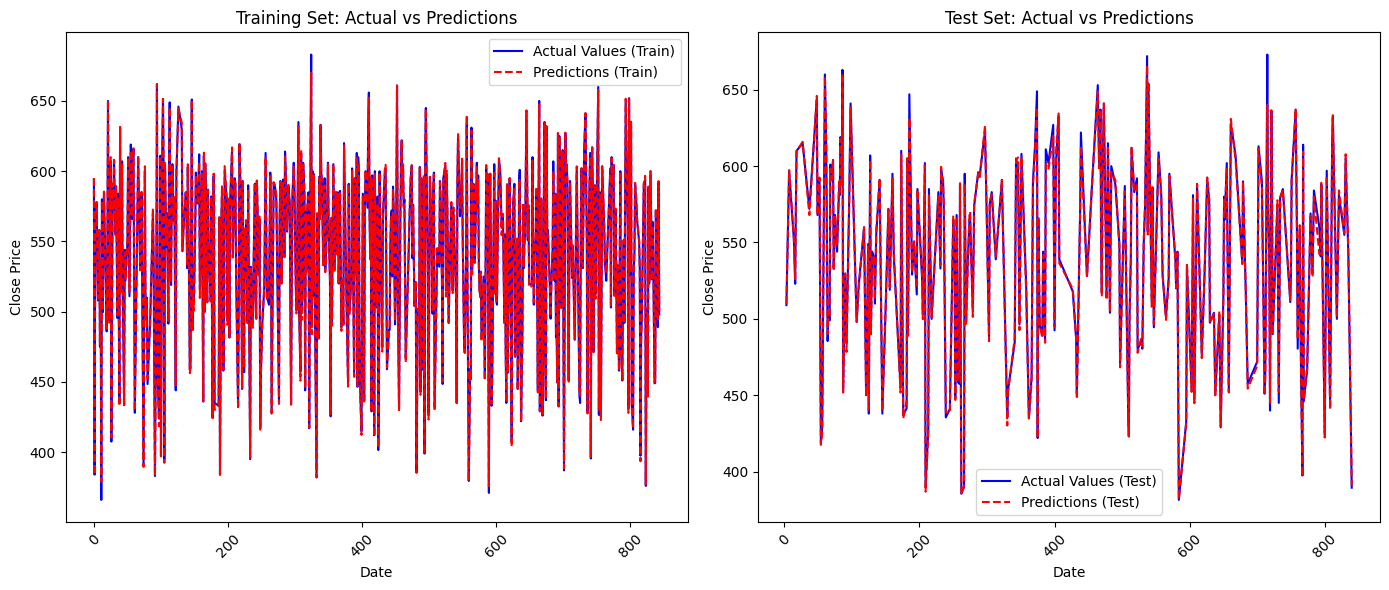

Best PCA n_components: 4
SVR with Best PCA Evaluation:
SVR with Best PCA Evaluation:
均方误差 (MSE): 123.20617530172159
均方根误差 (RMSE): 11.099827714956731
平均绝对误差 (MAE): 4.7485323021998616
R-squared score: 0.9711465932485865
在容忍度 1.0% 范围内的正确比率: 0.82
----------------------------------------


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

def feature_selection_and_svr(features):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test, train_index, test_index = train_test_split(
        x, y, data.index, test_size=0.3, random_state=39830
    )

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x_train, y_train)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征训练 SVR
    x_train_selected = x_train[:, [feature_index[f] for f in top_features]]
    x_test_selected = x_test[:, [feature_index[f] for f in top_features]]
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    svr_model.fit(x_train_selected, y_train)
    
    # 获取训练集和测试集的预测值
    predictions_train = svr_model.predict(x_train_selected)
    predictions_test = svr_model.predict(x_test_selected)
    
    # 打印模型评估结果
    print("SVR with Selected Features Evaluation:")
    evaluate_model(y_train, predictions_train, "SVR with Selected Features (Train)")
    evaluate_model(y_test, predictions_test, "SVR with Selected Features (Test)")

    # 绘制实际值与预测值的折线图
    plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    # 选择 1 到特征数的范围
    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        # 使用 PCA 转换后的数据训练 SVR
        svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
        svr_model_pca.fit(x_train_pca, y_train)
        
        predictions_pca = svr_model_pca.predict(x_test_pca)
        
        # 评估模型性能
        score = mean_squared_error(y_test, predictions_pca)
        r2 = r2_score(y_test, predictions_pca)
        
        # print(f"n_components = {i}, MSE = {score}, R-squared = {r2}")
        
        # 选择表现最佳的 PCA 组件数
        if r2 > best_score:
            best_score = r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca
            best_predictions = predictions_pca

    print(f'Best PCA n_components: {best_n_components}')
    # print(pca.components_)
    
    # 打印最佳 PCA 模型的评估结果
    print("SVR with Best PCA Evaluation:")
    evaluate_model(y_test, best_predictions, "SVR with Best PCA")

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Close' 列的 DataFrame，索引应为日期
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是索引
    if data.index.name != 'Date':
        # 'Date' 列已经是索引
        data.index.name = 'Date'
    
    # 获取训练集和测试集的日期
    train_dates = data.index[data.index.isin(train_index)]
    test_dates = data.index[data.index.isin(test_index)]
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


# 假设 data 是你的 DataFrame 和 features 是你的特征列表
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'sma', 'rsi', 'ma', 'std_dev', 'upperband', 'lowerband', 'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'MACD_Histogram']
feature_selection_and_svr(features)


Top 10 features selected: ['Low', 'High', 'Open', 'Adj Close', 'EMA12', 'EMA26', 'sma', 'ma', 'upperband', 'lowerband']
SVR with Selected Features Evaluation:
SVR with Selected Features (Train) Evaluation:
均方误差 (MSE): 1.335691927655048
均方根误差 (RMSE): 1.1557213884215556
平均绝对误差 (MAE): 0.6653966083817144
R-squared score: 0.9998899626921852
在容忍度 1.0% 范围内的正确比率: 0.90
----------------------------------------
SVR with Selected Features (Test) Evaluation:
均方误差 (MSE): 20419.968137770567
均方根误差 (RMSE): 142.8984539376496
平均绝对误差 (MAE): 54.04883456145001
R-squared score: -0.9860120255439107
在容忍度 1.0% 范围内的正确比率: 0.14
----------------------------------------


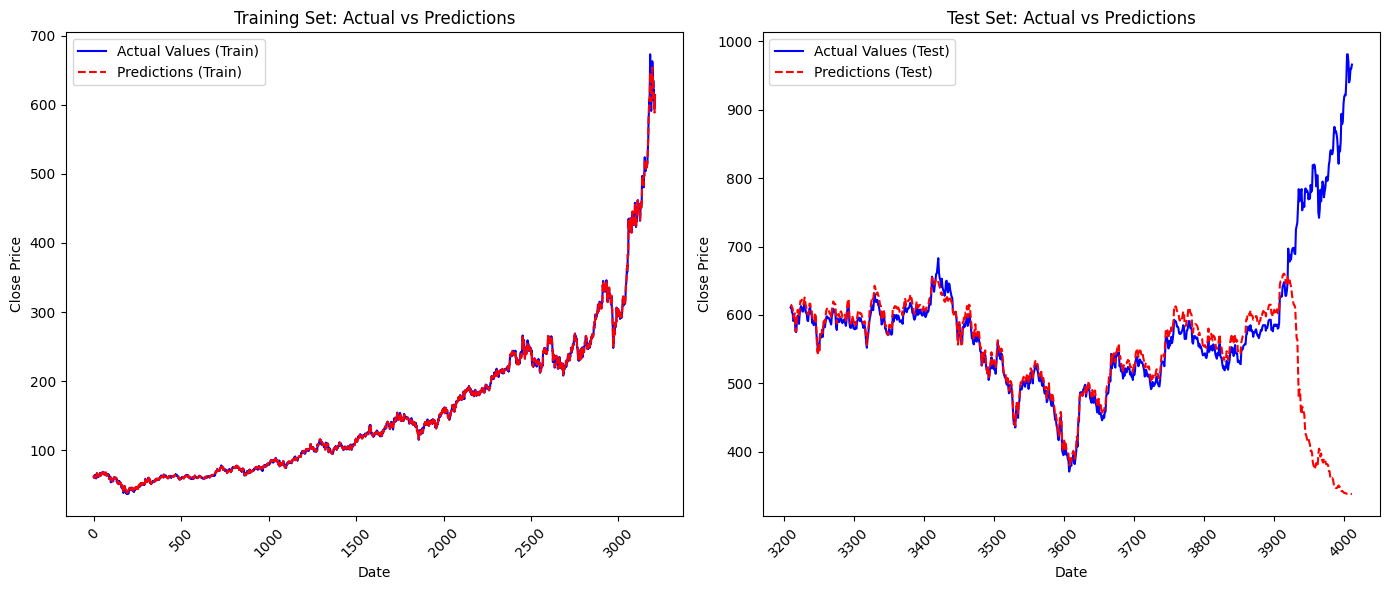

Best PCA n_components: 3
SVR with Best PCA Evaluation:
SVR with Best PCA Evaluation:
均方误差 (MSE): 22865.069904792697
均方根误差 (RMSE): 151.21200317697236
平均绝对误差 (MAE): 64.3012677696511
R-squared score: -1.223818543175176
在容忍度 1.0% 范围内的正确比率: 0.26
----------------------------------------


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

def feature_selection_and_svr(features):
    # 目标数据
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    # 特征数据
    x = data[features].values
    y = tdf['Target'].values
    
    # 指定训练集（前80%）和测试集（后20%）
    train_size = int(len(data) * 0.8)
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # 使用整个数据集的索引作为测试集
    train_index = data.index[:train_size]
    test_index = data.index[train_size:]

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x_train, y_train)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征训练 SVR
    x_train_selected = x_train[:, [feature_index[f] for f in top_features]]
    x_test_selected = x_test[:, [feature_index[f] for f in top_features]]
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    svr_model.fit(x_train_selected, y_train)
    
    # 获取训练集和测试集的预测值
    predictions_train = svr_model.predict(x_train_selected)
    predictions_test = svr_model.predict(x_test_selected)
    
    # 打印模型评估结果
    print("SVR with Selected Features Evaluation:")
    evaluate_model(y_train, predictions_train, "SVR with Selected Features (Train)")
    evaluate_model(y_test, predictions_test, "SVR with Selected Features (Test)")

    # 绘制实际值与预测值的折线图
    plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    # 选择 1 到特征数的范围
    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        # 使用 PCA 转换后的数据训练 SVR
        svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
        svr_model_pca.fit(x_train_pca, y_train)
        
        predictions_pca = svr_model_pca.predict(x_test_pca)
        
        # 评估模型性能
        score = mean_squared_error(y_test, predictions_pca)
        r2 = r2_score(y_test, predictions_pca)
        
        # print(f"n_components = {i}, MSE = {score}, R-squared = {r2}")
        
        # 选择表现最佳的 PCA 组件数
        if r2 > best_score:
            best_score = r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca
            best_predictions = predictions_pca

    print(f'Best PCA n_components: {best_n_components}')
    # print(pca.components_)
    
    # 打印最佳 PCA 模型的评估结果
    print("SVR with Best PCA Evaluation:")
    evaluate_model(y_test, best_predictions, "SVR with Best PCA")

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Date' 和 'Close' 列的 DataFrame
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是索引
    if data.index.name != 'Date':
        # 'Date' 列已经是索引
        data.index.name = 'Date'
    
    # 获取训练集和测试集的日期
    train_dates = data.index[data.index.isin(train_index)]
    test_dates = data.index[data.index.isin(test_index)]
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_pred, model_name):
    merror = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(merror)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation:")
    print(f'均方误差 (MSE): {merror}')
    print(f'均方根误差 (RMSE): {rmse}')
    print(f'平均绝对误差 (MAE): {mae}')
    print(f'R-squared score: {r2}')
    tolerance_percentage = 0.01  # 1%

    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')
    print('-' * 40)

feature_selection_and_svr(features)


Top 10 features selected: ['High', 'Low', 'Open', 'Adj Close', 'EMA12', 'upperband', 'EMA26', 'sma', 'ma', 'lowerband']
Cross-validation MSE (without PCA): 4.5294 ± 1.2607
Cross-validation MAE (without PCA): 1.1724 ± 0.0609
Cross-validation R-squared (without PCA): 0.9999 ± 0.0000
Cross-validation SVR (without PCA) - MSE: 4.4373, MAE: 1.1734, R-squared: 0.9999
在容忍度 1.0% 范围内的正确比率: 0.90


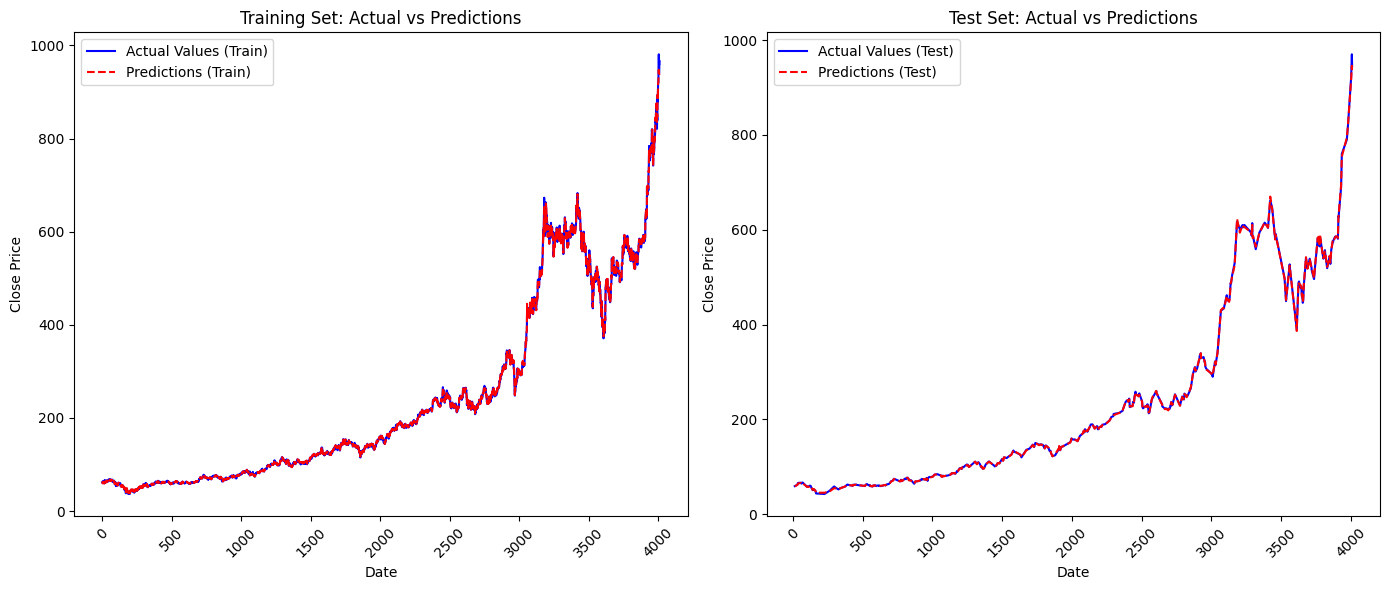

Best PCA n_components: 2
SVR with Best PCA Evaluation:
Cross-validation SVR with Best PCA - MSE: 35.9568, MAE: 1.8986, R-squared: 0.9991
在容忍度 1.0% 范围内的正确比率: 0.77


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    tolerance_percentage = 0.01  # 1%
    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

def feature_selection_and_svr(features, fold):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征
    x_selected = x[:, [feature_index[f] for f in top_features]]

    # 标准化特征
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_selected)

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=True, random_state=39830)
    
    # 没有 PCA 的 SVR
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    
    mse_scores = []
    mae_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(x_scaled):
        x_train, x_test = x_scaled[train_index], x_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        svr_model.fit(x_train, y_train)
        predictions_test = svr_model.predict(x_test)
        
        # 记录每折的评估指标
        mse_scores.append(mean_squared_error(y_test, predictions_test))
        mae_scores.append(mean_absolute_error(y_test, predictions_test))
        r2_scores.append(r2_score(y_test, predictions_test))

    print(f"Cross-validation MSE (without PCA): {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Cross-validation MAE (without PCA): {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Cross-validation R-squared (without PCA): {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    evaluate_model(y_test, predictions_test, "Cross-validation SVR (without PCA)")

    # 绘制训练集和测试集的实际值与预测值的折线图
    # 注意：在交叉验证中，数据集被分割成多个训练集和测试集，因此这里展示的绘图是最后一个折叠的结果
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions_train = svr_model.predict(x_train)
    predictions_test = svr_model.predict(x_test)
    plot_predictions_vs_actuals(data, data.index[train_index], data.index[test_index], y_train, y_test, predictions_train, predictions_test)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_scaled_pca = pca.fit_transform(x_scaled)
        
        mse_scores = []
        r2_scores = []

        for train_index, test_index in kf.split(x_scaled_pca):
            x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
            svr_model_pca.fit(x_train_pca, y_train)
            predictions_pca = svr_model_pca.predict(x_test_pca)
            
            mse_scores.append(mean_squared_error(y_test, predictions_pca))
            r2_scores.append(r2_score(y_test, predictions_pca))

        mean_r2 = np.mean(r2_scores)
        if mean_r2 > best_score:
            best_score = mean_r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca

    print(f'Best PCA n_components: {best_n_components}')

    # 打印最佳 PCA 模型的评估结果
    if best_model:
        x_scaled_pca = best_pca.transform(x_scaled)
        x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_predictions = best_model.predict(x_test_pca)
        
        print("SVR with Best PCA Evaluation:")
        evaluate_model(y_test, best_predictions, "Cross-validation SVR with Best PCA")

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Close' 列的 DataFrame，索引应为日期
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是索引
    if data.index.name != 'Date':
        data.index.name = 'Date'
    
    # 获取训练集和测试集的日期
    train_dates = data.index[data.index.isin(train_index)]
    test_dates = data.index[data.index.isin(test_index)]
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# 运行没有 PCA 的 SVR
feature_selection_and_svr(features=features, fold=10)


Top 10 features selected: ['High', 'Low', 'Open', 'Adj Close', 'EMA12', 'EMA26', 'sma', 'ma', 'upperband', 'lowerband']
Fold 1: MSE: 5.7574, MAE: 2.0327, R-squared: 0.9986
Fold 2: MSE: 9.9511, MAE: 2.3703, R-squared: 0.9977
Fold 3: MSE: 12.8994, MAE: 1.9999, R-squared: 0.9971
Fold 4: MSE: 11.4998, MAE: 2.3049, R-squared: 0.9977
Fold 5: MSE: 5.2152, MAE: 1.7504, R-squared: 0.9986
Fold 6: MSE: 7.6684, MAE: 1.9408, R-squared: 0.9976
Fold 7: MSE: 6.2331, MAE: 1.9763, R-squared: 0.9985
Fold 8: MSE: 5.9422, MAE: 1.8667, R-squared: 0.9984
Fold 9: MSE: 5.1361, MAE: 1.6456, R-squared: 0.9988
Fold 10: MSE: 4.3137, MAE: 1.6251, R-squared: 0.9990


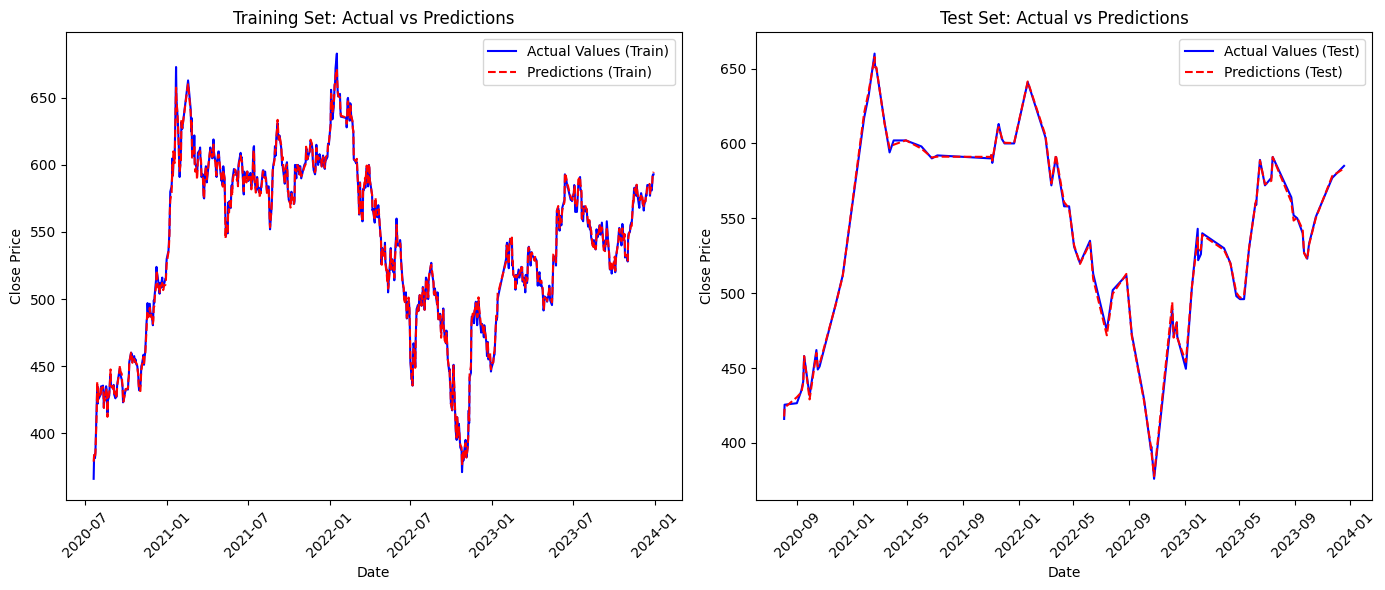


Overall Cross-validation Results (without PCA):
Mean MSE: 7.4616 ± 2.8143
Mean MAE: 1.9513 ± 0.2362
Mean R-squared: 0.9982 ± 0.0006
在容忍度 1.0% 范围内的正确比率: 0.96

Detailed Fold Results (without PCA):
   Fold        MSE       MAE  R-squared
0     1   5.757419  2.032725   0.998551
1     2   9.951059  2.370334   0.997704
2     3  12.899365  1.999905   0.997066
3     4  11.499786  2.304879   0.997684
4     5   5.215236  1.750378   0.998593
5     6   7.668356  1.940776   0.997615
6     7   6.233145  1.976298   0.998501
7     8   5.942222  1.866656   0.998438
8     9   5.136128  1.645568   0.998757
9    10   4.313699  1.625134   0.999022
Best PCA n_components: 3
SVR with Best PCA Evaluation:
Cross-validation SVR with Best PCA - MSE: 10.9170, MAE: 2.3903, R-squared: 0.9975
在容忍度 1.0% 范围内的正确比率: 0.90


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    tolerance_percentage = 0.01  # 1%
    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

def feature_selection_and_svr(features, fold,tolerance_percentage):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征
    x_selected = x[:, [feature_index[f] for f in top_features]]

    # # 标准化特征
    # scaler = StandardScaler()
    # x_scaled = scaler.fit_transform(x_selected)

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=True, random_state=39830)
    
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    
    mse_scores = []
    mae_scores = []
    r2_scores = []
    fold_results = []
    all_absolute_errors = []  # 保存所有折的绝对误差

    for fold_index, (train_index, test_index) in enumerate(kf.split(x_selected), 1):
        x_train, x_test = x_selected[train_index], x_selected[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        svr_model.fit(x_train, y_train)
        predictions_test = svr_model.predict(x_test)
        
        mse = mean_squared_error(y_test, predictions_test)
        mae = mean_absolute_error(y_test, predictions_test)
        r2 = r2_score(y_test, predictions_test)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        # 计算绝对误差
        absolute_errors = np.abs(predictions_test - y_test)
        all_absolute_errors.extend(absolute_errors)
        
        fold_results.append({
            'Fold': fold_index,
            'MSE': mse,
            'MAE': mae,
            'R-squared': r2
        })
        
        print(f"Fold {fold_index}: MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

        # 绘制最后一折的训练集和测试集的实际值与预测值的折线图
        if fold_index == fold:
            x_train, x_test = x_selected[train_index], x_selected[test_index]
            y_train, y_test = y[train_index], y[test_index]
            predictions_train = svr_model.predict(x_train)
            predictions_test = svr_model.predict(x_test)
            plot_predictions_vs_actuals(data, data.index[train_index], data.index[test_index], y_train, y_test, predictions_train, predictions_test)

    print(f"\nOverall Cross-validation Results (without PCA):")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean R-squared: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    
    
    tolerance_threshold = tolerance_percentage * np.mean(y)  # 基于目标变量的平均值计算容忍度阈值

    # 计算容忍度范围内的正确比率
    correct_within_tolerance = np.mean(np.array(all_absolute_errors) <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

    # 打印每一折的详细结果
    fold_results_df = pd.DataFrame(fold_results)
    print(f"\nDetailed Fold Results (without PCA):")
    print(fold_results_df)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_scaled_pca = pca.fit_transform(x_selected)
        
        mse_scores = []
        r2_scores = []

        for fold_index, (train_index, test_index) in enumerate(kf.split(x_scaled_pca), 1):
            x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
            svr_model_pca.fit(x_train_pca, y_train)
            predictions_pca = svr_model_pca.predict(x_test_pca)
            
            mse_scores.append(mean_squared_error(y_test, predictions_pca))
            r2_scores.append(r2_score(y_test, predictions_pca))

        mean_r2 = np.mean(r2_scores)
        if mean_r2 > best_score:
            best_score = mean_r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca

    print(f'Best PCA n_components: {best_n_components}')

    # 打印最佳 PCA 模型的评估结果
    if best_model:
        x_scaled_pca = best_pca.transform(x_selected)
        x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_predictions = best_model.predict(x_test_pca)
        
        print("SVR with Best PCA Evaluation:")
        evaluate_model(y_test, best_predictions, "Cross-validation SVR with Best PCA")

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Close' 和 'Date' 列的 DataFrame
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是日期类型
    if not pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = pd.to_datetime(data['Date'])
    
    # 获取训练集和测试集的实际日期
    train_dates = data.loc[train_index, 'Date']
    test_dates = data.loc[test_index, 'Date']
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


# 运行没有 PCA 的 SVR
feature_selection_and_svr(features=features, fold=10,tolerance_percentage = 0.01)


Top 10 features selected: ['High', 'Low', 'Open', 'Adj Close', 'EMA12', 'upperband', 'EMA26', 'sma', 'ma', 'lowerband']
Fold 1: MSE: 6.4406, MAE: 1.1337, R-squared: 0.9998
Fold 2: MSE: 4.8984, MAE: 1.2812, R-squared: 0.9999
Fold 3: MSE: 3.6559, MAE: 1.1084, R-squared: 0.9999
Fold 4: MSE: 3.2381, MAE: 1.1456, R-squared: 0.9999
Fold 5: MSE: 5.8345, MAE: 1.1061, R-squared: 0.9998
Fold 6: MSE: 3.6033, MAE: 1.1757, R-squared: 0.9999
Fold 7: MSE: 6.5118, MAE: 1.2827, R-squared: 0.9998
Fold 8: MSE: 3.3724, MAE: 1.1369, R-squared: 0.9999
Fold 9: MSE: 3.1189, MAE: 1.1544, R-squared: 0.9999
Fold 10: MSE: 4.4695, MAE: 1.1723, R-squared: 0.9999


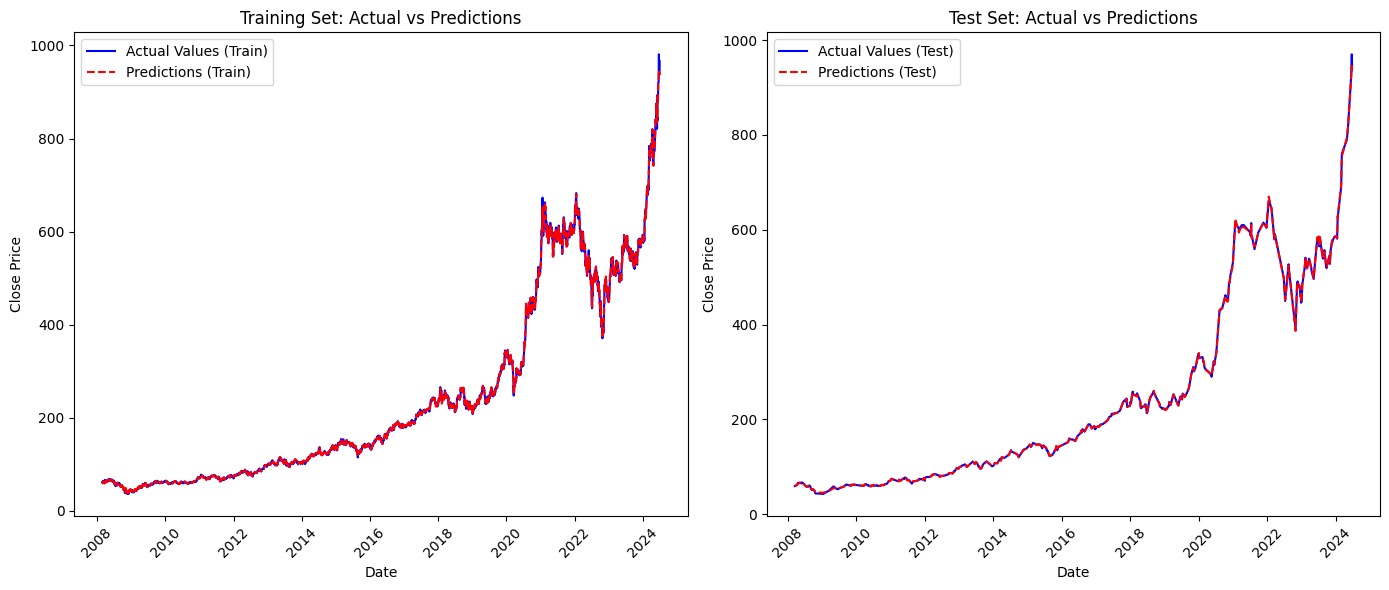


Overall Cross-validation Results (without PCA):
Mean MSE: 4.5143 ± 1.2665
Mean MAE: 1.1697 ± 0.0602
Mean R-squared: 0.9999 ± 0.0000
在容忍度 1.0% 范围内的正确比率: 0.88

Detailed Fold Results (without PCA):
   Fold       MSE       MAE  R-squared
0     1  6.440561  1.133742   0.999827
1     2  4.898390  1.281239   0.999889
2     3  3.655862  1.108450   0.999900
3     4  3.238058  1.145649   0.999926
4     5  5.834539  1.106070   0.999850
5     6  3.603281  1.175732   0.999915
6     7  6.511763  1.282726   0.999829
7     8  3.372413  1.136914   0.999916
8     9  3.118910  1.154387   0.999931
9    10  4.469541  1.172294   0.999882


In [15]:
def feature_selection_and_svr(features, fold, tolerance_percentage):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征
    x_selected = x[:, [feature_index[f] for f in top_features]]

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=True, random_state=39830)
    
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    
    mse_scores = []
    mae_scores = []
    r2_scores = []
    fold_results = []
    all_absolute_errors = []  # 保存所有折的绝对误差

    for fold_index, (train_index, test_index) in enumerate(kf.split(x_selected), 1):
        x_train, x_test = x_selected[train_index], x_selected[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        svr_model.fit(x_train, y_train)
        predictions_test = svr_model.predict(x_test)
        
        mse = mean_squared_error(y_test, predictions_test)
        mae = mean_absolute_error(y_test, predictions_test)
        r2 = r2_score(y_test, predictions_test)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        # 计算绝对误差
        absolute_errors = np.abs(predictions_test - y_test)
        all_absolute_errors.extend(absolute_errors)
        
        fold_results.append({
            'Fold': fold_index,
            'MSE': mse,
            'MAE': mae,
            'R-squared': r2
        })
        
        print(f"Fold {fold_index}: MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

        # 绘制最后一折的训练集和测试集的实际值与预测值的折线图
        if fold_index == fold:
            x_train, x_test = x_selected[train_index], x_selected[test_index]
            y_train, y_test = y[train_index], y[test_index]
            predictions_train = svr_model.predict(x_train)
            predictions_test = svr_model.predict(x_test)
            plot_predictions_vs_actuals(data, data.index[train_index], data.index[test_index], y_train, y_test, predictions_train, predictions_test)

    print(f"\nOverall Cross-validation Results (without PCA):")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean R-squared: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    
    
    tolerance_threshold = tolerance_percentage * np.mean(y)  # 基于目标变量的平均值计算容忍度阈值

    # 计算容忍度范围内的正确比率
    correct_within_tolerance = np.mean(np.array(all_absolute_errors) <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

    # 打印每一折的详细结果
    fold_results_df = pd.DataFrame(fold_results)
    print(f"\nDetailed Fold Results (without PCA):")
    print(fold_results_df)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_scaled_pca = pca.fit_transform(x_selected)
        
        mse_scores = []
        r2_scores = []

        for fold_index, (train_index, test_index) in enumerate(kf.split(x_scaled_pca), 1):
            x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
            svr_model_pca.fit(x_train_pca, y_train)
            predictions_pca = svr_model_pca.predict(x_test_pca)
            
            mse_scores.append(mean_squared_error(y_test, predictions_pca))
            r2_scores.append(r2_score(y_test, predictions_pca))

        mean_r2 = np.mean(r2_scores)
        if mean_r2 > best_score:
            best_score = mean_r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca

    print(f'Best PCA n_components: {best_n_components}')

    # 打印最佳 PCA 模型的评估结果
    if best_model:
        x_scaled_pca = best_pca.transform(x_selected)
        x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_predictions = best_model.predict(x_test_pca)
        
        print("SVR with Best PCA Evaluation:")
        evaluate_model(y_test, best_predictions, "Cross-validation SVR with Best PCA")
    
    return svr_model, best_model, best_pca,top_features  # 返回 SVR 模型和最佳 PCA 模型

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Close' 和 'Date' 列的 DataFrame
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是日期类型
    if not pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = pd.to_datetime(data['Date'])
    
    # 获取训练集和测试集的实际日期
    train_dates = data.loc[train_index, 'Date']
    test_dates = data.loc[test_index, 'Date']
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    tolerance_percentage = 0.01  # 1%
    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')
        
svr_model_no_pca, svr_model_with_pca, best_pca,selected_fea=feature_selection_and_svr(features=features, fold=10,tolerance_percentage = 0.01)

In [7]:
selected_fea

['High',
 'Low',
 'Open',
 'Adj Close',
 'EMA12',
 'upperband',
 'EMA26',
 'sma',
 'ma',
 'lowerband']

In [ ]:
test_data=pd.read_csv("2330.csv")
test_data

svr_model_no_pca - MSE: 10140.6427, MAE: 84.0572, R-squared: -5.2921
在容忍度 1.0% 範圍內的正確比率: 0.03
svr_model_with_pca - MSE: 36964.1926, MAE: 159.9248, R-squared: -21.9356
在容忍度 1.0% 範圍內的正確比率: 0.00


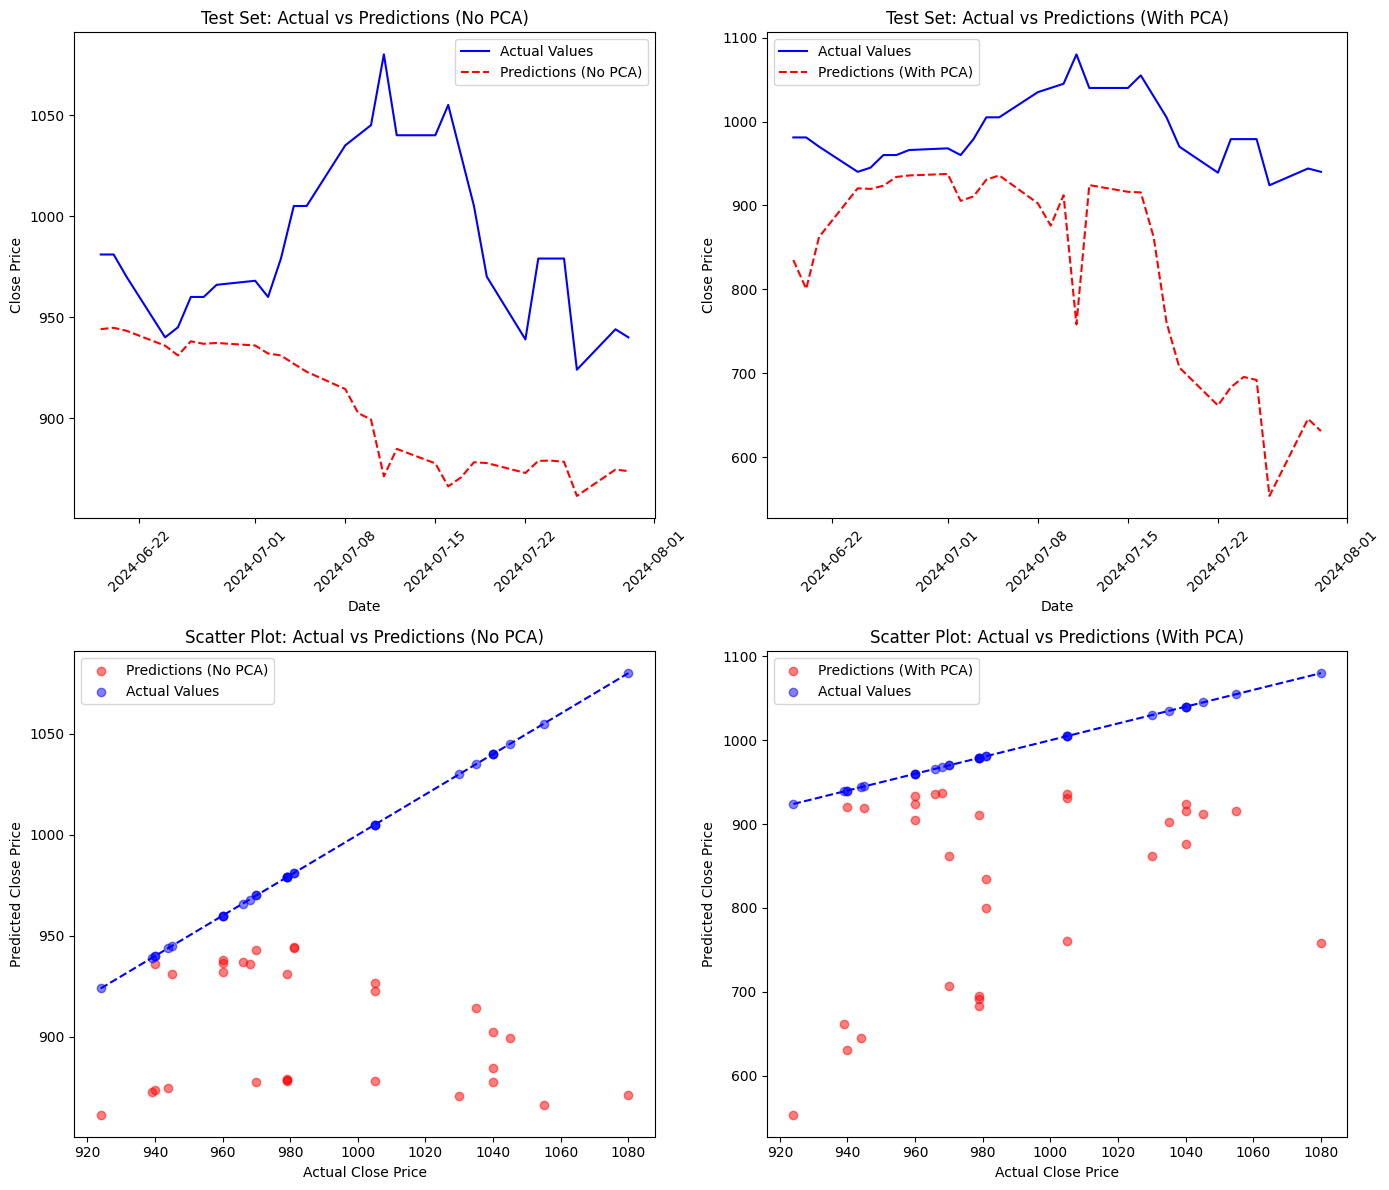

In [12]:
def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    tolerance_percentage = 0.01  # 1%
    tolerance_threshold = tolerance_percentage * np.abs(y_true)
    absolute_errors = np.abs(y_pred - y_true)
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 範圍內的正確比率: {correct_within_tolerance:.2f}')

def t_plot_predictions_vs_actuals(test_data, t_y, predictions_no_pca, predictions_with_pca=None):
    if not pd.api.types.is_datetime64_any_dtype(test_data['Date']):
        test_data['Date'] = pd.to_datetime(test_data['Date'])
    
    test_dates = test_data['Date']
    
    plt.figure(figsize=(14, 12))
    
    plt.subplot(2, 2, 1)
    plt.plot(test_dates, t_y, label='Actual Values', color='blue')
    plt.plot(test_dates, predictions_no_pca, label='Predictions (No PCA)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions (No PCA)')
    plt.legend()
    plt.xticks(rotation=45)
    
    if predictions_with_pca is not None:
        plt.subplot(2, 2, 2)
        plt.plot(test_dates, t_y, label='Actual Values', color='blue')
        plt.plot(test_dates, predictions_with_pca, label='Predictions (With PCA)', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title('Test Set: Actual vs Predictions (With PCA)')
        plt.legend()
        plt.xticks(rotation=45)
    
    # 新增散佈圖
    plt.subplot(2, 2, 3)
    plt.scatter(t_y, predictions_no_pca, color='red', alpha=0.5, label='Predictions (No PCA)')
    plt.scatter(t_y, t_y, color='blue', alpha=0.5, label='Actual Values')
    plt.xlabel('Actual Close Price')
    plt.ylabel('Predicted Close Price')
    plt.title('Scatter Plot: Actual vs Predictions (No PCA)')
    plt.plot([min(t_y), max(t_y)], [min(t_y), max(t_y)], color='blue', linestyle='--')
    plt.legend()

    if predictions_with_pca is not None:
        plt.subplot(2, 2, 4)
        plt.scatter(t_y, predictions_with_pca, color='red', alpha=0.5, label='Predictions (With PCA)')
        plt.scatter(t_y, t_y, color='blue', alpha=0.5, label='Actual Values')
        plt.xlabel('Actual Close Price')
        plt.ylabel('Predicted Close Price')
        plt.title('Scatter Plot: Actual vs Predictions (With PCA)')
        plt.plot([min(t_y), max(t_y)], [min(t_y), max(t_y)], color='blue', linestyle='--')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
test_data = pd.read_csv("2330.csv")
t_x = test_data[selected_fea].values
t_y = test_data['Close'].values

predictions_no_pca = svr_model_no_pca.predict(t_x)
evaluate_model(t_y, predictions_no_pca, "svr_model_no_pca")

if best_pca:
    t_x_pca = best_pca.transform(t_x)
    predictions_with_pca = svr_model_with_pca.predict(t_x_pca)
    evaluate_model(t_y, predictions_with_pca, "svr_model_with_pca")
else:
    predictions_with_pca = np.nan

t_plot_predictions_vs_actuals(test_data, t_y, predictions_no_pca, predictions_with_pca)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def feature_selection_and_lstm(data, features, fold, tolerance_percentage):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征
    x_selected = x[:, [feature_index[f] for f in top_features]]

    # 归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_scaled = scaler.fit_transform(x_selected)
    
    # 创建 LSTM 输入
    def create_dataset(x, y, time_step=1):
        x_data, y_data = [], []
        for i in range(len(x)-time_step-1):
            x_data.append(x[i:(i+time_step), :])
            y_data.append(y[i + time_step])
        return np.array(x_data), np.array(y_data)
    
    time_step = 10
    x_data, y_data = create_dataset(x_scaled, y, time_step)

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=True, random_state=39830)
    
    mse_scores = []
    mae_scores = []
    r2_scores = []
    all_absolute_errors = []  # 保存所有折的绝对误差

    for fold_index, (train_index, test_index) in enumerate(kf.split(x_data), 1):
        x_train, x_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        
        # 建立 LSTM 模型
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(time_step, x_scaled.shape[1])))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        
        # 训练模型
        model.fit(x_train, y_train, batch_size=1, epochs=1, verbose=1)
        
        # 预测
        predictions_test = model.predict(x_test)
        
        mse = mean_squared_error(y_test, predictions_test)
        mae = mean_absolute_error(y_test, predictions_test)
        r2 = r2_score(y_test, predictions_test)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        # 计算绝对误差
        absolute_errors = np.abs(predictions_test - y_test)
        all_absolute_errors.extend(absolute_errors)
        
        print(f"Fold {fold_index}: MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    print(f"\nOverall Cross-validation Results (LSTM):")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean R-squared: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

    tolerance_threshold = tolerance_percentage * np.mean(y)  # 基于目标变量的平均值计算容忍度阈值

    # 计算容忍度范围内的正确比率
    correct_within_tolerance = np.mean(np.array(all_absolute_errors) <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

    return model

# 使用示例
# svr_model_no_pca, svr_model_with_pca, best_pca,selected_fea = feature_selection_and_svr(data, features=features, fold=10,tolerance_percentage = 0.01)
lstm_model = feature_selection_and_lstm(data, features=features, fold=10, tolerance_percentage=0.01)


In [13]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

def feature_selection_and_arima(data, features, fold, tolerance_percentage):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=False)
    
    mse_scores = []
    mae_scores = []
    r2_scores = []
    all_absolute_errors = []  # 保存所有折的绝对误差

    for fold_index, (train_index, test_index) in enumerate(kf.split(y), 1):
        y_train, y_test = y[train_index], y[test_index]

        
        # 建立 ARIMA 模型
        model = ARIMA(y_train, order=(5, 1, 0))  # (p, d, q) 需要根据具体数据进行调整
        model_fit = model.fit()
        
        # 预测
        predictions_test = model_fit.forecast(steps=len(y_test))
        print(predictions_test)
        mse = mean_squared_error(y_test, predictions_test)
        mae = mean_absolute_error(y_test, predictions_test)
        r2 = r2_score(y_test, predictions_test)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        # 计算绝对误差
        absolute_errors = np.abs(predictions_test - y_test)
        all_absolute_errors.extend(absolute_errors)
        
        print(f"Fold {fold_index}: MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    print(f"\nOverall Cross-validation Results (ARIMA):")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean R-squared: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

    tolerance_threshold = tolerance_percentage * np.mean(y)  # 基于目标变量的平均值计算容忍度阈值

    # 计算容忍度范围内的正确比率
    correct_within_tolerance = np.mean(np.array(all_absolute_errors) <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

    return model_fit

# 使用示例
arima_model = feature_selection_and_arima(data, features=features, fold=10, tolerance_percentage=0.01)


Top 10 features selected: ['High', 'Low', 'Open', 'Adj Close', 'EMA12', 'upperband', 'EMA26', 'sma', 'ma', 'lowerband']
[965.78358206 965.49841439 965.58124055 965.57802762 965.63367061
 965.6340871  965.62866435 965.62870551 965.62872131 965.62928943
 965.62933247 965.62925747 965.62924772 965.62924848 965.62925481
 965.62925577 965.62925484 965.62925461 965.62925462 965.6292547
 965.62925471 965.6292547  965.6292547  965.6292547  965.6292547
 965.6292547  965.6292547  965.6292547  965.6292547  965.6292547
 965.6292547  965.6292547  965.6292547  965.6292547  965.6292547
 965.6292547  965.6292547  965.6292547  965.6292547  965.6292547
 965.6292547  965.6292547  965.6292547  965.6292547  965.6292547
 965.6292547  965.6292547  965.6292547  965.6292547  965.6292547
 965.6292547  965.6292547  965.6292547  965.6292547  965.6292547
 965.6292547  965.6292547  965.6292547  965.6292547  965.6292547
 965.6292547  965.6292547  965.6292547  965.6292547  965.6292547
 965.6292547  965.6292547  965.6

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold

def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    tolerance_percentage = 0.01  # 1%
    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

def feature_selection_and_svr(data, features, fold, tolerance_percentage):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征
    x_selected = x[:, [feature_index[f] for f in top_features]]

    # 划分数据集：训练集、验证集和测试集
    x_train, x_temp, y_train, y_temp = train_test_split(x_selected, y, test_size=0.3, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=True, random_state=39830)
    
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    
    mse_scores = []
    mae_scores = []
    r2_scores = []
    fold_results = []
    all_absolute_errors = []  # 保存所有折的绝对误差

    for fold_index, (train_index, test_index) in enumerate(kf.split(x_train), 1):
        x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        svr_model.fit(x_train_fold, y_train_fold)
        predictions_test_fold = svr_model.predict(x_test_fold)
        
        mse = mean_squared_error(y_test_fold, predictions_test_fold)
        mae = mean_absolute_error(y_test_fold, predictions_test_fold)
        r2 = r2_score(y_test_fold, predictions_test_fold)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        # 计算绝对误差
        absolute_errors = np.abs(predictions_test_fold - y_test_fold)
        all_absolute_errors.extend(absolute_errors)
        
        fold_results.append({
            'Fold': fold_index,
            'MSE': mse,
            'MAE': mae,
            'R-squared': r2
        })
        
        print(f"Fold {fold_index}: MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    print(f"\nOverall Cross-validation Results (without PCA):")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean R-squared: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    
    tolerance_threshold = tolerance_percentage * np.mean(y)  # 基于目标变量的平均值计算容忍度阈值

    # 计算容忍度范围内的正确比率
    correct_within_tolerance = np.mean(np.array(all_absolute_errors) <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

    # 打印每一折的详细结果
    fold_results_df = pd.DataFrame(fold_results)
    print(f"\nDetailed Fold Results (without PCA):")
    print(fold_results_df)

    # 使用验证集进行模型评估
    svr_model.fit(x_train, y_train)
    val_predictions = svr_model.predict(x_val)
    evaluate_model(y_val, val_predictions, "Validation Set")

    # 使用测试集进行模型评估
    test_predictions = svr_model.predict(x_test)
    evaluate_model(y_test, test_predictions, "Test Set")

    return svr_model, top_features

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Close' 和 'Date' 列的 DataFrame
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是日期类型
    if not pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = pd.to_datetime(data['Date'])
    
    # 获取训练集和测试集的实际日期
    train_dates = data.loc[train_index, 'Date']
    test_dates = data.loc[test_index, 'Date']
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# 使用示例
svr_model, top_features = feature_selection_and_svr(data, features=features, fold=10, tolerance_percentage=0.01)


Top 10 features selected: ['High', 'Low', 'Open', 'Adj Close', 'EMA12', 'upperband', 'EMA26', 'sma', 'ma', 'lowerband']
Fold 1: MSE: 8.1014, MAE: 1.2684, R-squared: 0.9998
Fold 2: MSE: 3.1370, MAE: 1.0611, R-squared: 0.9999
Fold 3: MSE: 3.7335, MAE: 1.1954, R-squared: 0.9999
Fold 4: MSE: 4.5219, MAE: 1.3743, R-squared: 0.9999
Fold 5: MSE: 12.0026, MAE: 1.2561, R-squared: 0.9997
Fold 6: MSE: 15.6909, MAE: 1.4132, R-squared: 0.9996
Fold 7: MSE: 10.5538, MAE: 1.3869, R-squared: 0.9997
Fold 8: MSE: 4.7031, MAE: 1.3552, R-squared: 0.9999
Fold 9: MSE: 5.6006, MAE: 1.2955, R-squared: 0.9999
Fold 10: MSE: 4.9585, MAE: 1.3935, R-squared: 0.9999

Overall Cross-validation Results (without PCA):
Mean MSE: 7.3003 ± 3.9577
Mean MAE: 1.3000 ± 0.1042
Mean R-squared: 0.9998 ± 0.0001
在容忍度 1.0% 范围内的正确比率: 0.86

Detailed Fold Results (without PCA):
   Fold        MSE       MAE  R-squared
0     1   8.101403  1.268375   0.999800
1     2   3.137023  1.061077   0.999909
2     3   3.733545  1.195400   0.999904


Top 10 features selected: ['Close', 'High', 'Low', 'Open', 'Adj Close', 'EMA12', 'upperband', 'EMA26', 'sma', 'ma']
Fold 1: MSE: 2610.5746, MAE: 12.2716, R-squared: 0.9299
Fold 2: MSE: 2547.7143, MAE: 12.3959, R-squared: 0.9425
Fold 3: MSE: 2544.8016, MAE: 11.8690, R-squared: 0.9305
Fold 4: MSE: 2530.6548, MAE: 12.1980, R-squared: 0.9421
Fold 5: MSE: 2569.0919, MAE: 12.1004, R-squared: 0.9338
Fold 6: MSE: 2490.7695, MAE: 12.4730, R-squared: 0.9411
Fold 7: MSE: 2592.2112, MAE: 12.8144, R-squared: 0.9320
Fold 8: MSE: 2502.9621, MAE: 11.7623, R-squared: 0.9374
Fold 9: MSE: 2479.6311, MAE: 11.8012, R-squared: 0.9449
Fold 10: MSE: 2594.8422, MAE: 11.7932, R-squared: 0.9318


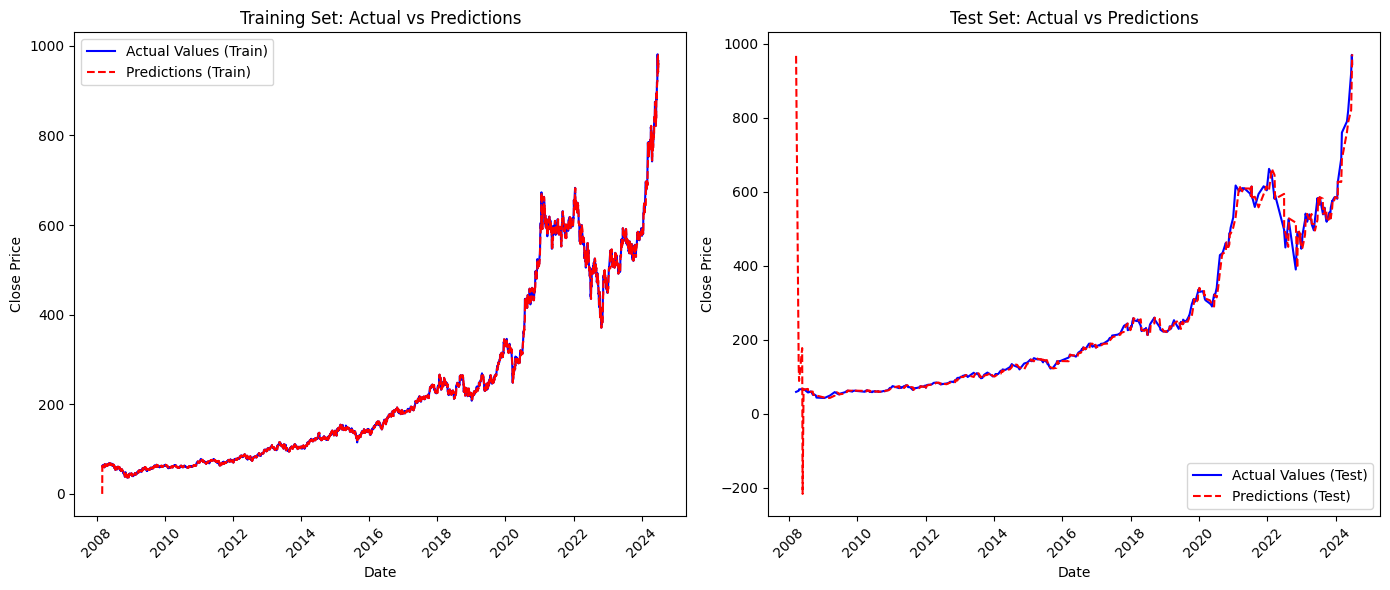


Overall Cross-validation Results (ARIMA):
Mean MSE: 2546.3253 ± 43.3249
Mean MAE: 12.1479 ± 0.3322
Mean R-squared: 0.9366 ± 0.0054
在容忍度 1.0% 范围内的正确比率: 0.40

Detailed Fold Results (ARIMA):
   Fold          MSE        MAE  R-squared
0     1  2610.574604  12.271585   0.929922
1     2  2547.714326  12.395883   0.942503
2     3  2544.801567  11.869023   0.930500
3     4  2530.654816  12.198045   0.942127
4     5  2569.091902  12.100385   0.933790
5     6  2490.769480  12.473012   0.941086
6     7  2592.211187  12.814388   0.931971
7     8  2502.962070  11.762348   0.937413
8     9  2479.631119  11.801174   0.944874
9    10  2594.842186  11.793238   0.931777


In [47]:
def feature_selection_and_arima(data, features, fold, tolerance_percentage):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征
    x_selected = x[:, [feature_index[f] for f in top_features]]

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=True, random_state=39830)
    
    mse_scores = []
    mae_scores = []
    r2_scores = []
    fold_results = []
    all_absolute_errors = []  # 保存所有折的绝对误差

    for fold_index, (train_index, test_index) in enumerate(kf.split(x_selected), 1):
        y_train, y_test = y[train_index], y[test_index]

        # 使用 ARIMA 模型进行训练和预测
        arima_model = ARIMA(y_train, order=(5, 1, 0))  # 这里的 order 参数需要根据实际数据进行调整
        arima_model_fit = arima_model.fit()
        
        # 使用滚动预测逐步预测测试集数据
        predictions_test = []
        history = list(y_train)
        for t in range(len(y_test)):
            model = ARIMA(history, order=(5, 1, 0))
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions_test.append(yhat)
            history.append(y_test[t])

        mse = mean_squared_error(y_test, predictions_test)
        mae = mean_absolute_error(y_test, predictions_test)
        r2 = r2_score(y_test, predictions_test)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        # 计算绝对误差
        absolute_errors = np.abs(predictions_test - y_test)
        all_absolute_errors.extend(absolute_errors)
        
        fold_results.append({
            'Fold': fold_index,
            'MSE': mse,
            'MAE': mae,
            'R-squared': r2
        })
        
        print(f"Fold {fold_index}: MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

        # 绘制最后一折的训练集和测试集的实际值与预测值的折线图
        if fold_index == fold:
            plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, arima_model_fit.fittedvalues, predictions_test)

    print(f"\nOverall Cross-validation Results (ARIMA):")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean R-squared: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    
    tolerance_threshold = tolerance_percentage * np.mean(y)  # 基于目标变量的平均值计算容忍度阈值

    # 计算容忍度范围内的正确比率
    correct_within_tolerance = np.mean(np.array(all_absolute_errors) <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

    # 打印每一折的详细结果
    fold_results_df = pd.DataFrame(fold_results)
    print(f"\nDetailed Fold Results (ARIMA):")
    print(fold_results_df)

    return arima_model_fit, top_features  # 返回 ARIMA 模型和选择的特征

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, fitted_values, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Close' 和 'Date' 列的 DataFrame
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - fitted_values: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是日期类型
    if not pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = pd.to_datetime(data['Date'])
    
    # 获取训练集和测试集的实际日期
    train_dates = data.loc[train_index, 'Date']
    test_dates = data.loc[test_index, 'Date']
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, fitted_values, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    tolerance_percentage = 0.01  # 1%
    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

# 调用函数
arima_model_fit, selected_features = feature_selection_and_arima(data, features, fold=10, tolerance_percentage=0.01)